In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

### Read in prepared validation data

In [2]:
validation_ready <- readRDS(paste0(TMP_DIR,"validation-measure.Rds")) %>% filter(model == "five_latent_purity", complete_rna) %>% unique()
hmf_loo <- readRDS(paste0(TMP_DIR, "validation-loo-cv.Rds"))
cpi_go <- readRDS(paste0(I_DIR, "cpi_go.Rds")) %>% transmute(patient_id = substr(sampleId,0,12), tmb_high = factor(ifelse(exp(tmb) > 9, "TMB High", "TMB Low"), levels = c("TMB Low", "TMB High")))

In [3]:
dd <- (
    validation_ready
        %>% left_join(cpi_go, by = "patient_id")
        %>% select( patient_id, Study, tissue, tmb, tcell, bor, os_days, os_event, os, tmb_high)
        %>% left_join(hmf_loo, by = "patient_id")
        %>% mutate( tissue = str_to_title(tissue))
        %>% drop_na(bor)
        %>% drop_na(tcell)
)

In [4]:
dfs <- list(
    "HMF-CPCT" = dd %>% filter(Study == "HMF-CPCT") %>% unique() %>% mutate(tissue = "Pan-Cancer"),
    "Melanoma" = dd %>% filter(Study == "HMF-CPCT", tissue == "Skin") %>% unique(),
    "Lung" = dd %>% filter(Study == "HMF-CPCT", tissue == "Lung") %>% unique(),
    "Bladder" = dd %>% filter(Study == "HMF-CPCT", tissue == "Bladder") %>% unique(), 
    "Other" = dd %>% filter(Study == "HMF-CPCT", tissue == "Other") %>% unique()
)

In [5]:
saveRDS(dfs, file = paste0(TMP_DIR, "figure5_data.Rds"))

### 0 - Distibution plots slim

In [6]:
dist_plotter <- function(df, theme) {
    (
    ggplot(data = df, aes(y=Study, x=ct, fill = tmb_high, label = ct)) 
    + geom_bar(stat="identity", alpha = .4, width=.8, position = 'stack', color = "black") 
    + scale_fill_manual(values = c("TMB Low" = my_palette[1], "TMB High" = my_palette[3]))
    + geom_text(size = 9, position = position_stack(vjust = .5))
    + theme + theme(axis.title.x = element_text())
    )
}

In [7]:
names(dfs)

[1] "HMF-CPCT" "Melanoma" "Lung"     "Bladder"  "Other"

In [8]:
legend <- theme(legend.position = "top", legend.text = element_text(size=22), legend.title = element_blank())

In [9]:
eva <- list()
for(i in names(dfs)){
    eva[[i]] <- (
        dfs[[i]]
          %>% unique() 
          %>% group_by(Study, tmb_high) 
          %>% summarise( ct = n())
          %>% mutate(tmb_high = factor(tmb_high, levels = c("TMB High", "TMB Low")))
    )
}

dist_plts2 <- list()
for (i in names(dfs)) { 
    dist_plts2[[i]] <- dist_plotter(eva[[i]], theme = theme_dist)
    if( i == "HMF-CPCT"){
        dist_plts2[[i]] <- dist_plts2[[i]] + labs( x = "HMF CPI samples with complete data") + ggtitle("Pan-Cancer") + theme(plot.title = element_text(size = 30)) + legend 
    } else {
        dist_plts2[[i]] <- dist_plts2[[i]] + theme(axis.title.x = element_blank()) + ggtitle(i) + theme(plot.title = element_text(size = 20))
    }
}

`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.


### 2 - Percent Responders within Groups

In [10]:
computer <- function(df) {
    a <- (df
       %>% group_by(tmb_high)
       %>% summarise(bor = mean(bor), non_bor = 1-mean(bor), ct = n())
       %>% gather("gp", "bor", -ct, -tmb_high)
       %>% mutate(bor2 = paste0(round(bor,2)*100, "%"))
       %>% filter(gp == "bor")
    )
    a
}
plotter <- function(df, theme){
    (
    ggplot(data = df, aes(x=tmb_high, y=bor, fill = gp, label = bor2, color = tmb_high, alpha = .4)) 
    + geom_bar(stat="identity", width=.8, position = 'stack', size = 1, alpha = .4)     
    + scale_fill_manual(values = c("dark grey", "dark grey"))
    + labs( x = "Responders" )
    + scale_color_manual(values = c("TMB High" = my_palette[3], "TMB Low" = my_palette[1]))
    + scale_y_continuous(breaks=c(0,.7), labels = scales::percent_format(scale = 100), limits = c(0,1))    
    + theme 
    )
}

#### Compute responders

In [11]:
responders <- list()
for(i in names(dfs)) {
    responders[[i]] = computer(dfs[[i]])
}

#### Store responder plots

In [12]:
responder_plts <- list()
for(i in names(responders)) {
    if( i %in% c("HMF-CPCT")) {
        responder_plts[[i]] <- plotter( responders[[i]], theme = theme_compute_main + theme(axis.title.x = element_text())) + geom_text(size = 8.5, vjust = -.2, color = "black")
    } else {
        responder_plts[[i]] <- plotter( responders[[i]], theme = theme_compute_tissue + theme(axis.title.x = element_text())) + geom_text(size = 7, vjust = -.2, color = "black")
    }
}

### 3 - Combining Plots

#### Make the table

In [13]:
overall <- arrangeGrob(dist_plts2[['HMF-CPCT']],responder_plts[['HMF-CPCT']], nrow = 2)
mel <- arrangeGrob(dist_plts2[['Melanoma']],responder_plts[['Melanoma']], nrow = 2)
lun <- arrangeGrob(dist_plts2[['Lung']],responder_plts[['Lung']], nrow = 2)
bla <- arrangeGrob(dist_plts2[['Bladder']],responder_plts[['Bladder']], nrow = 2)
oth <- arrangeGrob(dist_plts2[['Other']],responder_plts[['Other']], nrow = 2)
hmf_tissue <- arrangeGrob(mel,lun,bla,oth, ncol = 2)

#### All together

In [14]:
together_high_tmb <- as_ggplot(arrangeGrob(overall, hmf_tissue, layout_matrix = rbind(c(1,1,2,2,2),c(1,1,2,2,2))))

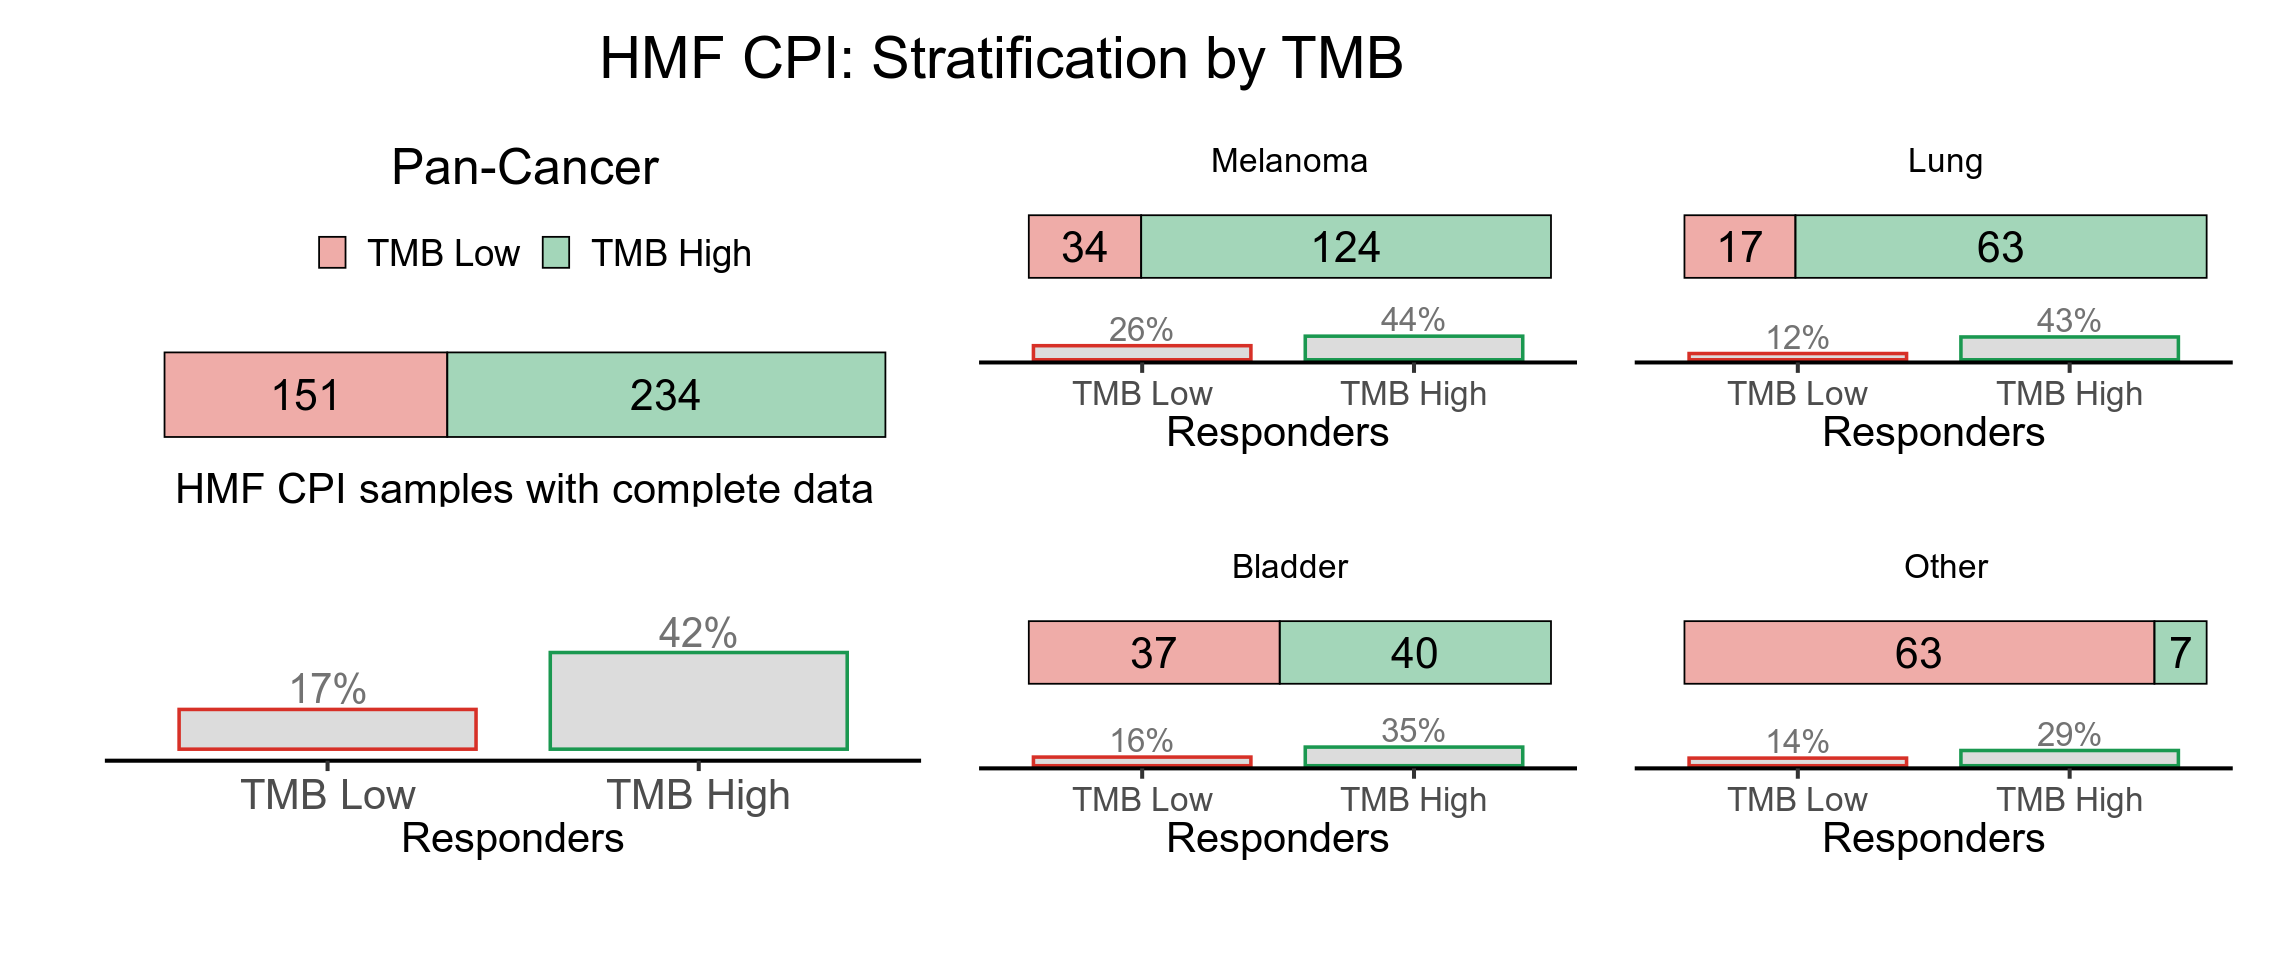

In [15]:
options(repr.plot.width=19, repr.plot.height=8)
together_high_tmb  + ggtitle("HMF CPI: Stratification by TMB") + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(vjust = 2, hjust = .4, size = 35))
#ggsave(file = paste0(FIG_FINAL_DIR, "figure5_c_high_tmb_supplement.png"), width = 19, height = 11)

In [16]:
saveRDS( together_high_tmb, file = paste0(FIG_DIR, "figure5_d.Rds"))